In [14]:
import warnings; warnings.simplefilter('ignore')

from scipy.io import wavfile
import pandas as pd
import numpy as np
from plotnine import *
theme_set(theme_bw())
from helper_functions import *

# Plotnine plot deconstruction: regularised logistic regression diagnostic plots
*Interpreting crossvalidation results of a logistic regression model that classifies drum samples*

Note that this is a companion article to [another article I wrote](https://towardsdatascience.com/expanding-your-regression-repertoire-with-regularisation-903d2c9f7b28), and although I tried to make this article self contained that article does go into more detail in regards to the statistics. This article focuses on how to make the diagnostic plots using `plotnine`. If you are not familiar with plotnine, [this article](https://www.datascienceworkshops.com/blog/plotnine-grammar-of-graphics-for-python/) provides a good introduction to the library. As with any of my articles you can also read the article on [github](https://github.com/PaulHiemstra/lasso_tsfresh_article/blob/master/logistic_regression_plots_article.ipynb). 

## Introduction
A major issue in statistics is underdetermination: a lack of data prevents us from choosing between models as they share the same performance based on that data. [Regularisation](https://en.wikipedia.org/wiki/Regularization_(mathematics)) helps us make this choice by introducing additional information into the problem. One common form of regularisation in regression is adding the norm of the model coefficients to the standard squared difference loss function. Various forms of this technique are called [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)), [Ridge regression](https://en.wikipedia.org/wiki/Tikhonov_regularization), or [Elastic Net regularisation](https://en.wikipedia.org/wiki/Elastic_net_regularization).  

When introducing [regularisation](https://en.wikipedia.org/wiki/Regularization_(mathematics)) into our regression method, a major choice we need to make is the regularisation strength, i.e. how much do we focus on the norm of the model coefficients versus the squared difference part of the loss function. A common way to select this [hyperparameter](https://machinelearningmastery.com/difference-between-a-parameter-and-a-hyperparameter/) is using crossvalidation. Whichever setting of the hyperparameter yields the best crossvalidation performance is chosen. 

The goal of this article is to construct a number of diagnostic plots which help you interpret the outcome of the crossvalidated regularisation strength. In this article you will learn about the following topics:

- How to preprocess the crossvalidation outcome for plotting in plotnine
    - Multi-dimensional numpy arrays to flat DataFrame's
    - Sorting categorical data to influence the order of plotting in plotnine
    - Flattening a column `MultiIndex` to just a single index level
- How to generate the plots using plotnine
    - Stacking multiple geometries
    - Using different data for different geometries
    - Using a custom label function

We will start this article off with a small introduction to the case study, before going on to constructing the diagnostic plots. 

## Classifying drum samples
Humans are really good at recognizing sounds. Based on one sound we can recognize if there is a bird or a bear nearby. Very skilled listeneres might even ben able to recognize the type of bird they hear. Transferring this kind of skill to a mathematical model is not trivial. In this article we focus on recognizing drum sounds: a kick drum (or bass), tom and snare drum in particular. Each sound is stored in a wav file, for example:

In [15]:
sample_rate, bass = wavfile.read('./sounds/bass1.wav')
bass_pd = pd.DataFrame(bass, columns=['left', 'right']).assign(time_id = range(len(bass)))
bass_pd.head()

,left,right,time_id
0,7,3,0
1,5,4,1
2,12,7,2
3,86,39,3
4,313,182,4


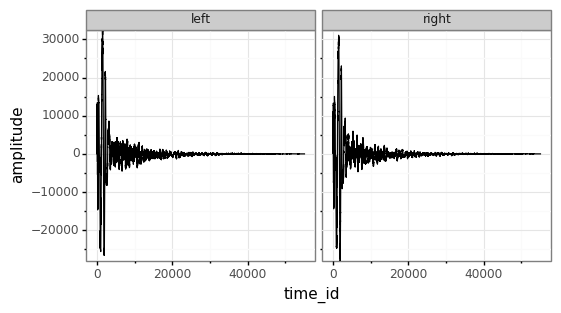

<ggplot: (8732780245233)>

In [16]:
gg = (
    ggplot(bass_pd.melt(id_vars = ['time_id'], value_name='amplitude', var_name='stereo')) 
      + geom_line(aes(x = 'time_id', 
                      y = 'amplitude'))
      + facet_wrap('stereo') 
      + theme(figure_size=(6,3))
)
gg.save(filename='pics/stereo_drum.png', dpi=600)
gg

where we see the amplitudes of the left and right channel over time. To train the model we need to take a number of steps:

- Read the data into memory
- Construct features based on each drum sample
- Use crossvalidation to determine the regularisation strength

the `generate_drum_model.py` script on github performs all these steps and dumps the results to disc. In the next section we will pick up the crossvalidation results and construct a number of useful diagnostic plots. 

## Diagnostic plots
The basis for the diagnostic plots are the crossvalidation results generated using [`LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Together with the original training data they are input to the diagnostic plots. We can read these from file as they have already been generated by running `generate_drum_model.py`: 

In [17]:
from joblib import dump, load

audio_tsfresh = pd.read_pickle('pkl/drum_tsfresh.pkl') # Load the original training data used
cv_result = load('pkl/drum_logreg_cv.joblib')

The main result of crossvalidation object is the selected regularisation strength, stored in the `C_` attribute:

In [18]:
np.log10(1/(2*cv_result.C_))

array([6.05011715, 6.05011715, 6.05011715])

note we transform the `C_` attribute here as `LogisticRegressionCV` from sklearn works with the inverse of the regularisation strength. I use the $\alpha$ definition that Lasso uses, which equals `1/2C`. I added the log transform to make the number more readable. 

Based on `cv_result` I will construct two diagnostic plots: one focusing on the coefficients of the model and one on the overall performance of the model. In both cases I will first show the plot, and then slowly break down each of the steps that are needed to make the plot. 

### Plot A: Development of coefficients
In the crossvalidation procedure we used an L1-norm, which means that coefficients in the model get pushed to zero as the regularisation strength increases. If you are unclear as to what the previous line said, I suggest reading [the compagnion article I wrote]() that explains the statistics in detail. 

To visualise this effect we make a plot of the coefficient values versus regularisation strength using the `plot_coef_paths` that can be found in the `helper_functions.py` file on github: 

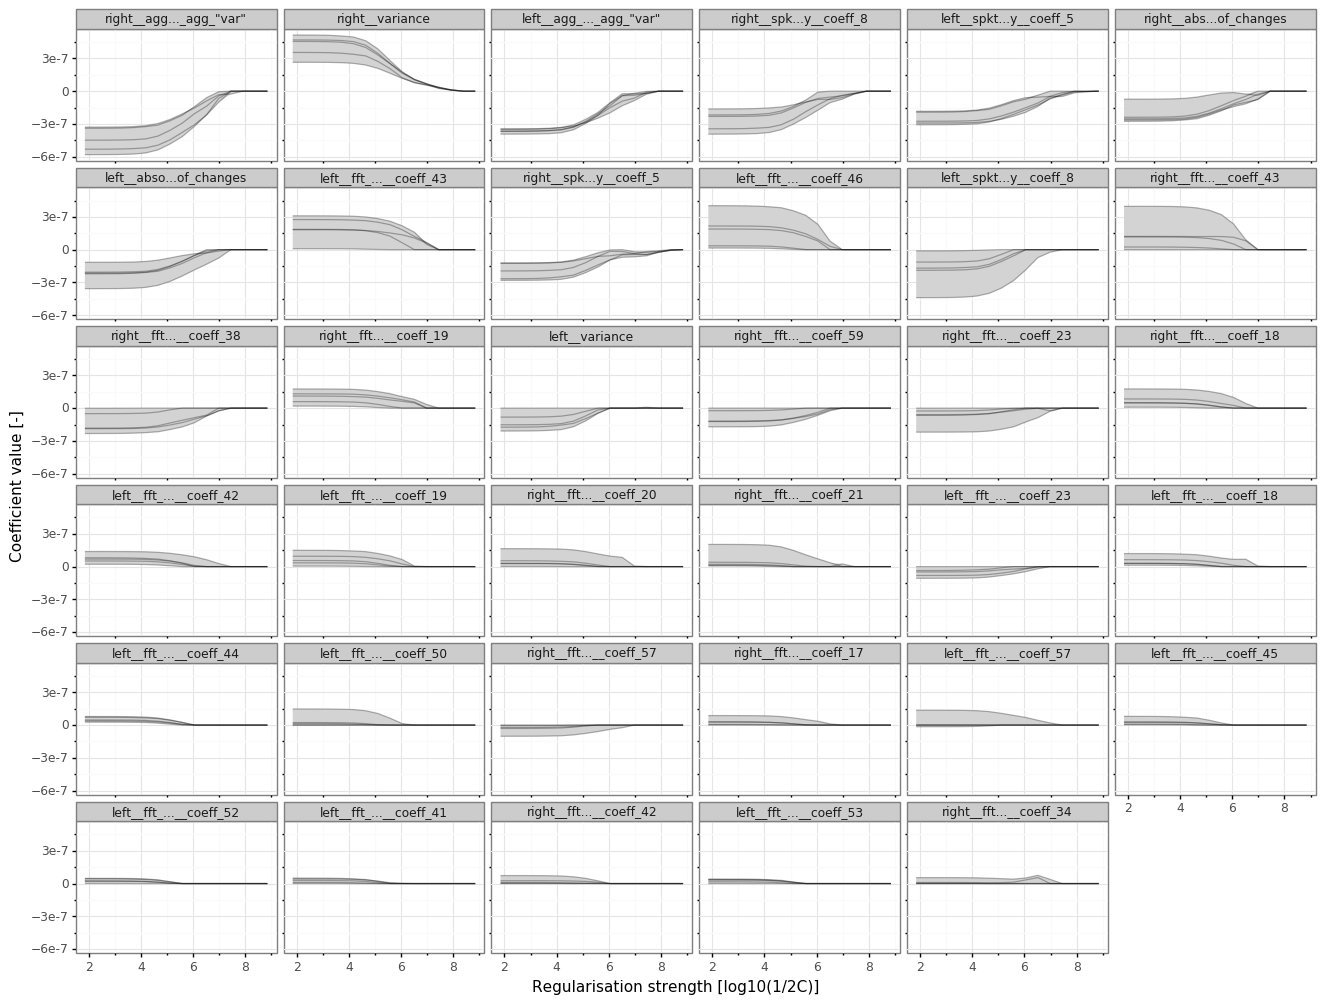

<ggplot: (8732774280065)>

In [37]:
gg = plot_coef_paths(cv_result, 'kick', audio_tsfresh) + theme(figure_size=(16,12))
gg.save(filename='pics/coef_paths.png', dpi=600)
gg

here we see how the coefficients for the `kick` model change for each feature versus the regularisation strength. Note that there are five lines in the plot, one for each of the crossvalidation folds. 

In the following sections I show each of the steps that are needed the produce the plot above. 

#### Step 1: wide to long data
The main source of data for this plot is the `coef_paths_` attribute of the `LogisticRegressionCV` object. This attribute stores a dictionary with an entry for each of the possible classes the model can predict: kick, snare and tom in our case. The values in the dictionary are [`numpy.ndarray`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) objects, which store all the coefficient values. The shape of the `ndarray` is:

In [20]:
cv_result.coefs_paths_['kick'].shape

(5, 16, 328)

for the `kick` model. The first axis is the crossvalidation fold, the second axis is regularisation strength and the third axis is the feature. 

Plotnine does not work with `ndarray` objects, but needs [a long format](https://www.theanalysisfactor.com/wide-and-long-data/#:~:text=In%20the%20long%20format%2C%20each,below%20in%20the%20long%20format.) where each row consists of a single coefficient value and their associated regularisation strength, coefficient name and model. [A very efficient way to generate this long format](https://stackoverflow.com/questions/36853594/easy-multidimensional-numpy-ndarray-to-pandas-dataframe-method) data frame based on a `ndarray` is to flatten the entire `ndarray` into a single column, and add a `MultiIndex` which shows to which fold, regularisation strength and feature the coefficient belongs. 

First we generate the single column array using `reshape`, which flattens to `(number of samples, 1 column)`:

In [21]:
kick_model = cv_result.coefs_paths_['kick']
single_column_array = kick_model.reshape(kick_model.size, 1)
single_column_array.shape

(26240, 1)

Next we generate the appropriate `MultiIndex` using [`pd.MultiIndex.from_product`](https://pandas.pydata.org/docs/reference/api/pandas.MultiIndex.from_product.html):

In [22]:
index = pd.MultiIndex.from_product([range(kick_model.shape[0]),                      # 0-4 folds (length 5)
                                    cv_result.Cs_,                                   # The regularisation strength values (length 16)
                                    list(audio_tsfresh.columns) + ['intercept']],    # The feature names, note we add `intercept` (length 328)
                                   names=['folds', 'reg_strength','feature_name'])   # The names of the nd array dimensions
print(index.shape)
index[0]

(26240,)


(0, 7.060782905266815e-10, 'left__absolute_sum_of_changes')

Note that the sizes in the nested list we pass to `pd.MultiIndex.from_product` exactly match the shape of the multidimensional array. This is because each of the elements in `index` contains the metadata for the correponding element in `single_column_array`. Each element in the metadata list `index` contains three elements (e.g. `index[0]`). Those are the metadata elements fold, regularisation strength and name of the feature respectively. 

Now we can combine the single column array with the `MultiIndex` as a `DataFrame`:

In [23]:
plot_data = pd.DataFrame(single_column_array, index=index, columns=['coef_value']).reset_index()
plot_data.head()

,folds,reg_strength,feature_name,coef_value
0,0,7.060783e-10,left__absolute_sum_of_changes,0.0
1,0,7.060783e-10,"right__agg_autocorrelation__f_agg_""median""__ma...",0.0
2,0,7.060783e-10,right__autocorrelation__lag_9,0.0
3,0,7.060783e-10,right__autocorrelation__lag_8,0.0
4,0,7.060783e-10,right__cid_ce__normalize_True,0.0


the resulting `DataFrame` has four columns. The first three are the metadata from the `MultiIndex`, the last one is the coefficient value from the single column array. 

Note we use `.reset_index()` because we need the columns in the index as normal columns for plotting. In `helper_functions.py` on github you can find the function `ndarray_to_long` function which performs this operation.

#### Step 2: transform C to $\alpha$ and apply log
The logistic regression functions in sklearn work with the inverse of the regularisation strength. However, I find working with the regularisation strength directly more intuitive. In this article I use the $\alpha$ definition for regularisation strength, which equals `1/2C`. In addition, I log transform the values to aid in readability of the plot as the values chosen for the regularisation strength follow a log distribution. For more details I refer to the `generate_drum_model.py` script on github. 

In [24]:
plot_data = plot_data.assign(reg_strength = np.log10(1/(2*plot_data["reg_strength"].astype('float'))))
plot_data['reg_strength'].head()

0    8.850117
1    8.850117
2    8.850117
3    8.850117
4    8.850117
Name: reg_strength, dtype: float64

#### Step 3: discard non-relevant features
Using tsfresh we generated 328 features for the model. Plotting all these 328 features in a plot including the development of their coefficients is simply too much. Therefore we only choose coefficients that have a mean coefficient size above a certain threshold. Choosing this cutoff involves a bit of trial-and-error. Here I chose a cutoff of `1e-8`:

In [25]:
coef_cutoff = '1e-8'
mean_coef_values = plot_data.groupby(['feature_name']).mean()
relevant_features = mean_coef_values.query('abs(coef_value) > %s' % coef_cutoff).index
plot_data = plot_data[plot_data['feature_name'].isin(relevant_features)]

Note the use of `abs(coef_value)` which ensures that we also include features that have negative coefficients. The exact value of the cutoff I probably something you want to experiment with if you make plots for your own analyses. 

#### Step 4: sort features from high to low coefficient value
In the plot we use a grid of subplots (facets) for each of the possible features. We want the most important feature to be in the top left corner of the grid as that is where most users will focus their attention first. In addition, we want the importance of the feature determine further sorting from left to right and top to bottom. We define the importance of a feature to be the mean absolute value of its coefficient. 

To force plotnine to use this order, we need to apply a sorting to the feature names column. We do this using the `pd.Categorical` function:

In [26]:
coef_from_high_to_low = (
    plot_data.groupby(['feature_name'])
      .mean()
      .abs()
      .sort_values(by='coef_value', ascending=False)
      .index
)
plot_data['feature_name'] = pd.Categorical(plot_data['feature_name'], categories=coef_from_high_to_low)

where the category sorting is done by looking at the absolute (`.abs`) mean (`.mean`) coefficient value per feature (`.groupby(['feature_name']`). Actually sorting the values is done using `.sort_values`. Also note that we use `.index` to return the feature names and not the sorted coefficient values. Based on the coefficient names sorted from important to less important we build the categorical variable. Important to remember here is that the actual values in `plot_data['feature_name']` are not sorted: the category order in the metadata is sorted.

#### Step 5: calculating min/max of the data
In the plot we use both a set of lines, one for each fold in the cross validation, and a ribbon which covers the min and max of the lines. So there is one ribbon and five lines in each of the facets. 

In preparation for the `geom_ribbon`, we need to precompute the min/max:

In [27]:
plot_data_min_max = plot_data.groupby(['reg_strength', 'feature_name']).agg(['min', 'max'])
plot_data_min_max

folds      \
                                                                  min max   
reg_strength feature_name                                                   
1.850117     right__agg_linear_trend__attr_"intercept"__chun...     0   4   
             right__variance                                        0   4   
             left__agg_linear_trend__attr_"intercept"__chunk...     0   4   
             right__spkt_welch_density__coeff_8                     0   4   
             left__spkt_welch_density__coeff_5                      0   4   
...                                                               ...  ..   
8.850117     left__fft_coefficient__attr_"abs"__coeff_52            0   4   
             left__fft_coefficient__attr_"abs"__coeff_41            0   4   
             right__fft_coefficient__attr_"abs"__coeff_42           0   4   
             left__fft_coefficient__attr_"abs"__coeff_53            0   4   
             right__fft_coefficient__attr_"abs"__coeff_34           0   4   

                                                                   coef_value  \
                                                                          min   
reg_strength feature_name                                                       
1.850117     right__agg_linear_trend__attr_"intercept"__chun... -5.813560e-07   
             right__variance                                     2.646393e-07   
             left__agg_linear_trend__attr_"intercept"__chunk... -3.935294e-07   
             right__spkt_welch_density__coeff_8                 -3.937117e-07   
             left__spkt_welch_density__coeff_5                  -3.078835e-07   
...                                                                       ...   
8.850117     left__fft_coefficient__attr_"abs"__coeff_52         0.000000e+00   
             left__fft_coefficient__attr_"abs"__coeff_41         0.000000e+00   
             right__fft_coefficient__attr_"abs"__coeff_42        0.000000e+00   
             left__fft_coefficient__attr_"abs"__coeff_53         0.000000e+00   
             right__fft_coefficient__attr_"abs"__coeff_34        0.000000e+00   

                                                                               
                                                                          max  
reg_strength feature_name                                                      
1.850117     right__agg_linear_trend__attr_"intercept"__chun... -3.289956e-07  
             right__variance                                     5.144502e-07  
             left__agg_linear_trend__attr_"intercept"__chunk... -3.452052e-07  
             right__spkt_welch_density__coeff_8                 -1.623742e-07  
             left__spkt_welch_density__coeff_5                  -1.841126e-07  
...                                                                       ...  
8.850117     left__fft_coefficient__attr_"abs"__coeff_52         0.000000e+00  
             left__fft_coefficient__attr_"abs"__coeff_41         0.000000e+00  
             right__fft_coefficient__attr_"abs"__coeff_42        0.000000e+00  
             left__fft_coefficient__attr_"abs"__coeff_53         0.000000e+00  
             right__fft_coefficient__attr_"abs"__coeff_34        0.000000e+00  

[560 rows x 4 columns]

Note that `.agg` results in a `MultiIndex` on the columns. For plotting in `plotnine` I just want to have a flat column name list. To flatten the `MultiIndex` I use:

In [28]:
plot_data_min_max.columns = ['_'.join(col).strip() for col in plot_data_min_max.columns.values] 

where I join all the levels in the `MultiIndex` using an `_`. For example, `('coef_value', 'min')` is flattened to `coef_value_min`. 

Finally I get rid of the row index as I want the columns available for use in `plotnine`:

In [29]:
plot_data_min_max = plot_data_min_max.reset_index()

#### Step 6: plotting in plotnine
Now we have all of our data ready, we can make the plot:

In [ ]:
(
    ggplot(plot_data) + 
      geom_ribbon(plot_data_min_max, aes(x='reg_strength', ymin='coef_value_min', ymax='coef_value_max'), fill='lightgrey') + 
      geom_line(aes(x='reg_strength', y='coef_value', group='folds'), alpha=0.3) + 
      facet_wrap('~ feature_name', labeller=abbreviate_label) + 
      labs(x='Regularisation strength [log10(1/2C)]', y='Coefficient value [-]')
)

Note here that I:

- use two geometries: a ribbon geometry based on the min and max of the data and a line geometry for the individual folds in the crossvalidation. 
- the ribbon geom has its own data (`plot_data_min_max`) and does not use the main plot data (`plot_data`). This is useful as the ribbon geometry does not use all the raw data for each fold, but just the min and max of the data. 
- use an alpha of 0.3 on the lines. This ensures that the lines do not dominate the plot, and we can spot overlapping lines. 
- use a custom label function in `facet_wrap`. The feature names that are generated by tsfresh are really big, too big to fit in the title box of a facet. To mitigate this issue I use a custom label function: `abbreviate_label` from `helper_functions.py`. This takes the head and tail of the string and connects them using `...`. This greatly improves the readability of the facet labels. 
- using `( )` around the code. This is to be able to use newlines without having to include `\` each time. 

### Plot B: overall performance versus regularisation strength
In the previous plot we looked at how the coefficient values for features changed with regularisation strength. In the second plot we focus on the overall performance of the plot. Performance in this case means the accuracy of the prediction, i.e. what fraction of the time the model predicts the correct type of drum. We make this plot using the `plot_reg_strength_vs_score` function from `helper_functions.py`:

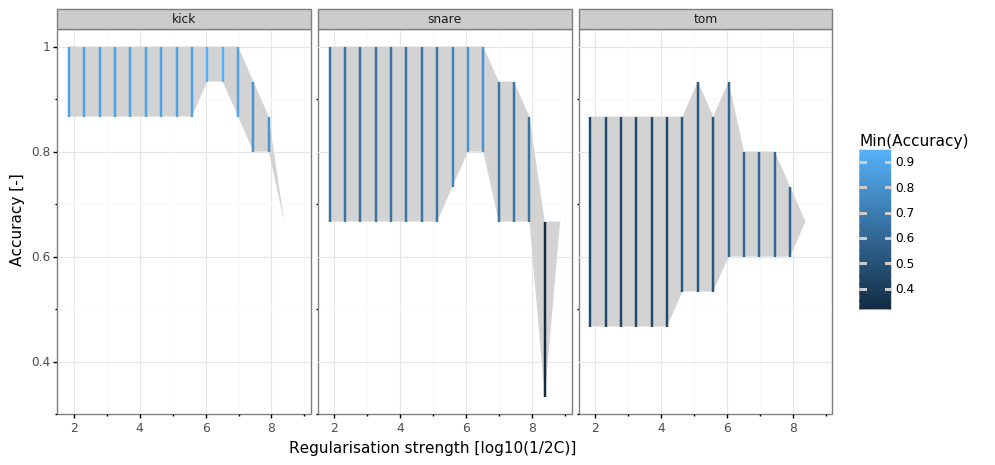

<ggplot: (8732775363453)>

In [38]:
gg = plot_reg_strength_vs_score(cv_result) + theme(figure_size=(10,5))
gg.save(filename='pics/overall_performance.png', dpi=600)
gg

Note that the accuracy spans a range of values for each regularisation strength, thus the use of a `geom_ribbon`. Having a range of values stems from having results for each of the folds in the crossvalidation. From the figure it is obvious that the `kick` model performs best and the tom model worst. Next we break down this plot and show you how to make it. 

#### Step 1: wide to long
Just as with the previous plot, we need to transform our data to the long format required for plotnine. For this we use the same `ndarray_to_long` function, for example for the `kick` model:

In [32]:
ndarray_to_long(cv_result.scores_['kick'],     
                [range(5), cv_result.Cs_],
                ['folds', 'reg_strength']).head()

,folds,reg_strength,coef_value
0,0,7.060783e-10,0.666667
1,0,2.067852e-09,0.666667
2,0,6.056005e-09,0.800000
3,0,1.773588e-08,0.866667
4,0,5.194210e-08,0.866667


Note that we have two axes here: the crossvalidation folds and the regularisation strength. 

Next we want to combine the data of all three models into one big DataFrame. For this we construct a helper function which uses `ndarray_to_long` per submodel and adds the name of the submodel. Next we use a list comprehension and the helper function to get the data for all submodels. Finally, we use `pd.concat` to glue all submodel data into one big `DataFrame`:

In [33]:
def get_data_per_model(cv_results, category):
    return ndarray_to_long(cv_results.scores_[category],     
                    [range(5), cv_results.Cs_],
                    ['folds', 'reg_strength'], 
                    value_colname = 'cv_score').assign(model_name = category)

plot_data = pd.concat([get_data_per_model(cv_result, mod) for mod in cv_result.classes_])
plot_data.head()

,folds,reg_strength,cv_score,model_name
0,0,7.060783e-10,0.666667,kick
1,0,2.067852e-09,0.666667,kick
2,0,6.056005e-09,0.800000,kick
3,0,1.773588e-08,0.866667,kick
4,0,5.194210e-08,0.866667,kick


This combination with a list comprehension and `pd.concat` is a very potent technique in my opinion. 

#### Step 2: transform C to $\alpha$ and apply log
As with the previous plot we transform the regularisation strength:

In [34]:
plot_data = plot_data.assign(reg_strength = np.log10(1/(2*plot_data["reg_strength"].astype('float'))))
plot_data.head()

,folds,reg_strength,cv_score,model_name
0,0,8.850117,0.666667,kick
1,0,8.383450,0.666667,kick
2,0,7.916784,0.800000,kick
3,0,7.450117,0.866667,kick
4,0,6.983450,0.866667,kick


#### Step 3: calculating min/max of the data
As input for the `geom_ribbon` we need the min/max of the accuracy data:

In [35]:
plot_data = (
    plot_data
      .drop(columns=['folds'])
      .groupby(['reg_strength', 'model_name'])
      .agg(['min', 'max'])
)
plot_data.columns = ['_'.join(col).strip() for col in plot_data.columns.values]     # Collapse MultiIndex in columns
plot_data = plot_data.reset_index()
plot_data.head()

,reg_strength,model_name,cv_score_min,cv_score_max
0,1.850117,kick,0.866667,1.000000
1,1.850117,snare,0.666667,1.000000
2,1.850117,tom,0.466667,0.866667
3,2.316784,kick,0.866667,1.000000
4,2.316784,snare,0.666667,1.000000


#### Step 4: plotting in plotnine
Now that we have all the data lined up, we can make the plot using plotnine:

In [ ]:
(
        ggplot(plot_data) + 
          geom_ribbon(aes(x='reg_strength', ymin='cv_score_min', ymax='cv_score_max'), fill='lightgrey') + 
          geom_segment(aes(x='reg_strength', xend='reg_strength', y='cv_score_min', yend='cv_score_max', color='cv_score_min'), size=1) + 
          scale_color_gradient() + 
          facet_wrap('~ model_name') + 
          labs(x='Regularisation strength [log10(1/2C)]', y = 'Accuracy [-]', color='Min(Accuracy)')
)

Note that I use both a ribbon and segment geometry. Using both geometries is because I find the plot more readable that way. 

### Acknowledgements
I want to thank Bernhard Terlaak who provided valueable feedback to a draft of this article.